In [117]:
# Pagel's lambda for growth rates
import numpy as np
import pandas as pd

import ete3
from tqdm import tqdm

from src.phylogenetic_signal import PagelsLambda

In [96]:
gg_tree_path = "./greengenes/data/gg_13_5_otus_99_annotated.tree"

In [107]:
# Datasets

def strip_df(df):
    # Strip whitespace from column names
    df.columns = df.columns.str.strip()
    
    # Values
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].str.strip()
    return df

# PTR
uhlemann_ptr = None

# Abundance
uhlemann_abundance = None
ibd_abundance = pd.read_csv("/home/phil/DATA/ihmp/IBD/ibd_16s_otu_table.csv", dtype={0: str})
ibd_abundance = ibd_abundance.set_index(ibd_abundance.columns[0])
moms_abundance = None
t2d_abundance = None

# Metadata
uhlemann_metadata = None
ibd_metadata = pd.read_csv("/home/phil/DATA/ihmp/IBD/hmp2_ibd_metadata.csv", index_col=0, skipinitialspace=True)
moms_metadata = None
t2d_metadata = None

# Turn IBD data into abundance changes
ibd_metadata = strip_df(ibd_metadata)
ibd_metadata = ibd_metadata[ibd_metadata["data_type"] == "stool_16S"]
ibd_metadata = ibd_metadata[["diagnosis", "Participant ID", "External ID", "week_num"]]
ibd_metadata.columns = ["disease", "patient", "sample", "week"]

ibd_abundance = strip_df(ibd_abundance)
ibd_abundance = ibd_abundance.T
ibd_abundance["sample"] = [x.split("_")[0] for x in ibd_abundance.index]

ibd_merged = pd.merge(ibd_abundance, ibd_metadata)
ibd_merged = ibd_merged.drop("sample", axis=1)
ibd_merged = ibd_merged.set_index(["disease", "patient", "week"])

ibd_diffs = ibd_merged.diff(axis=0).dropna() # Drop first row

/home/phil/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (12,13,14,40,46,55,65,66,67,68,177,294,298,299,300,301,304,305,306,307,308,309,310,318,320,328,330,346,348,350,352,354,359,361,363,366,373,377,381,383,418,419,432,433,434,435,436,438,439,440,441,442,444,445,446,447,448,450,451,452,453,454) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [112]:
ibd_diffs.shape

(97, 1370)

In [125]:
# Get tree
tree = ete3.Tree(gg_tree_path, format=1, quoted_node_names=True)

# How much overlap is there?
print(
    len(set(tree.get_leaf_names()) & set(ibd_diffs.columns))
    / len(set(ibd_diffs.columns))
)  # Hope for 1.0

# Get tree and dataframe in agreement
tree.prune(list(ibd_diffs.columns))  # Prune tree to OTUs in dataset
ibd_diffs.reindex(
    columns=tree.get_leaf_names()
)  # Reindex dataframe to OTUs in tree

# Get lambda values per-disease
pls = {"CD": [], "UC": [], "nonIBD": []}
pl = PagelsLambda(tree)
for i in tqdm(range(len(ibd_diffs))):
    row = ibd_diffs.iloc[i]
    x = row.values.reshape(-1, 1) # TODO: support DFs in PagelsLambda
    pl.fit(x)
    pls[row.name[0]].append(pl.lam) # Separate by disease


1.0


100%|██████████| 97/97 [19:20<00:00, 11.96s/it]


In [127]:
import pickle

with open("results/03_empirical.pkl", "wb") as f:
    pickle.dump(pls, f)

([<matplotlib.axis.XTick at 0x7f65bd4ce400>,
 [Text(1, 0, 'CD (N=76)'),
  Text(2, 0, 'UC (N=20)'),
  Text(3, 0, 'nonIBD (N=1)')])

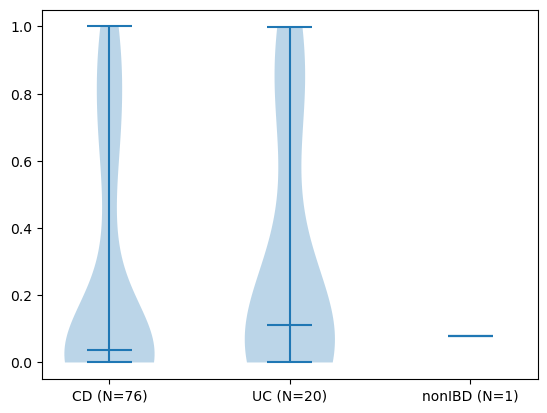

In [141]:
# Violin plot

import matplotlib.pyplot as plt

ks, vs = zip(*pls.items())
plt.violinplot(list(vs), showmedians=True)
ns = [len(item) for item in vs]

plt.xticks(range(1, len(k) + 1), [f"{k} (N={n})" for k, n in zip(ks, ns)])